# Fase 2: Treinamento do Modelo de Deep Learning

Neste notebook, vamos usar os dados preparados na Fase 1 para construir e treinar um modelo de Rede Neural Recorrente (LSTM) para prever os movimentos do mercado.


In [16]:
# CÉLULA 1: Importar Bibliotecas

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("Bibliotecas da Fase 2 importadas com sucesso!")
print(f"TensorFlow versão: {tf.__version__}")
from tensorflow.keras.callbacks import EarlyStopping


Bibliotecas da Fase 2 importadas com sucesso!
TensorFlow versão: 2.16.2


In [2]:
# CÉLULA 2 (CORRIGIDA): Carregar os dados processados

# Caminho correto para o ficheiro
processed_data_path = '../data/processed/final_btc_features.feather'

# Carregar os dados
try:
    df = pd.read_feather(processed_data_path)
    print("Dados processados carregados com sucesso!")
    print(f"Shape do dataframe: {df.shape}")
    display(df.head())
    
except FileNotFoundError:
    print(f"ERRO: Ficheiro não encontrado em '{processed_data_path}'")
    print("Certifique-se de que executou a célula para guardar os dados no notebook 01.")


Dados processados carregados com sucesso!
Shape do dataframe: (1777, 18)


,open,high,low,close,volume,daily_return,sma_20,ema_20,rsi_14,bollinger_upper,bollinger_lower,macd,macd_signal,day_of_week,day_of_month,week_of_year,month,label
date,,,,,,,,,,,,,,,,,,
2020-10-28 00:00:00+00:00,13636.16,13859.48,12888.00,13266.4,94440.561226,-0.027117,12109.8345,12301.793133,78.736145,13824.876220,10394.792780,572.657340,427.293139,2,28,44.0,10.0,-1
2020-10-29 00:00:00+00:00,13266.40,13642.91,12920.77,13455.7,74872.602132,0.014269,12230.0875,12411.689025,79.390192,13969.521392,10490.653608,588.589709,459.552453,3,29,44.0,10.0,-1
2020-10-30 00:00:00+00:00,13455.69,13669.98,13115.00,13560.1,70657.778881,0.007759,12343.4315,12521.061499,84.611773,14120.834635,10566.028365,602.692965,488.180556,4,30,44.0,10.0,-1
2020-10-31 00:00:00+00:00,13560.10,14100.00,13411.50,13791.0,67339.238515,0.017028,12464.5305,12642.008023,85.465008,14291.734086,10637.326914,625.293602,515.603165,5,31,44.0,10.0,-1
2020-11-01 00:00:00+00:00,13791.00,13895.00,13603.00,13761.5,36285.648526,-0.002139,12576.1930,12748.626306,84.077137,14435.159035,10717.226965,633.521524,539.186837,6,1,44.0,11.0,-1


In [3]:
# CÉLULA 3: Separar Features (X) e Alvo (y)

# 'y' é a nossa coluna alvo (o que queremos prever)
y = df['label']

# 'X' são todas as outras colunas que usaremos como features.
# Removemos o alvo e também as colunas de preço originais,
# pois já temos features melhores (retornos, indicadores, etc.).
X = df.drop(columns=['label', 'open', 'high', 'low', 'close'])

print("Features (X) e Alvo (y) separados com sucesso.")
print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")


Features (X) e Alvo (y) separados com sucesso.
Shape de X: (1777, 13)
Shape de y: (1777,)


In [4]:
# CÉLULA 4: Dividir em Conjuntos de Treino e Teste

# Dividir os dados. Usamos shuffle=False porque em séries temporais, a ordem importa.
# Queremos treinar com o passado e testar com o futuro.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Dados divididos em treino e teste.")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")


Dados divididos em treino e teste.
Shape de X_train: (1421, 13)
Shape de X_test: (356, 13)


In [5]:
# CÉLULA 5: Normalizar as Features

# Criar o normalizador
scaler = StandardScaler()

# Aprender a escala a partir dos dados de TREINO e aplicá-la
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar a MESMA escala aprendida aos dados de TESTE
X_test_scaled = scaler.transform(X_test)

print("Features normalizadas com sucesso.")


Features normalizadas com sucesso.


In [6]:
# CÉLULA 6: Criar sequências para a LSTM

def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Definir o número de passos no tempo (quantas velas passadas o modelo vai olhar)
TIME_STEPS = 60

# Criar as sequências
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

print("Dados transformados em sequências.")
print(f"Shape de X_train_seq: {X_train_seq.shape}")


Dados transformados em sequências.
Shape de X_train_seq: (1361, 60, 13)


In [7]:
# CÉLULA 7: Construir o modelo LSTM

model = Sequential()

# Camada LSTM 1
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))

# Camada LSTM 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Camada Densa de Saída
# Usamos 3 unidades porque temos 3 classes (Comprar, Vender, Neutro)
# A função de ativação 'softmax' dá-nos a probabilidade para cada classe
model.add(Dense(units=3, activation='softmax'))

# Compilar o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar um resumo da arquitetura
model.summary()


2025-09-20 14:38:04.599337: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-20 14:38:04.599367: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-20 14:38:04.599370: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-20 14:38:04.599546: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-20 14:38:04.599556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When u

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,153 (129.50 KB)

 Trainable params: 33,153 (129.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# CÉLULA 8 (MODIFICADA): Treinar o modelo com Early Stopping

# Como os nossos labels são -1, 0, 1, precisamos de os ajustar para 0, 1, 2
y_train_adj = y_train_seq + 1
y_test_adj = y_test_seq + 1

# Configurar o Early Stopping
# - monitor='val_loss': Observar a perda nos dados de validação.
# - patience=5: Número de épocas sem melhoria antes de parar o treino.
# - restore_best_weights=True: No final, restaurar os pesos do modelo da melhor época.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Aumentar o número de épocas para dar espaço ao Early Stopping para funcionar
EPOCHS = 100

# Treinar o modelo, agora passando o callback de early stopping
history = model.fit(
    X_train_seq, y_train_adj,
    epochs=EPOCHS,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping], # <-- ADICIONADO
    verbose=1
)

print("\\nTreino concluído!")


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8145 - loss: 0.4089 - val_accuracy: 0.7226 - val_loss: 0.6743
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8178 - loss: 0.4080 - val_accuracy: 0.7226 - val_loss: 0.6352
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7998 - loss: 0.4190 - val_accuracy: 0.7226 - val_loss: 0.6410
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8064 - loss: 0.4174 - val_accuracy: 0.7226 - val_loss: 0.6116
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8072 - loss: 0.4103 - val_accuracy: 0.7080 - val_loss: 0.6458
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8056 - loss: 0.4017 - val_accuracy: 0.7226 - val_loss: 0.6211
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8080 - loss: 0.4049 - val_accuracy: 0.7299 - val_loss: 0.6327
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8162 - loss: 0.3854 - val_accuracy: 0.

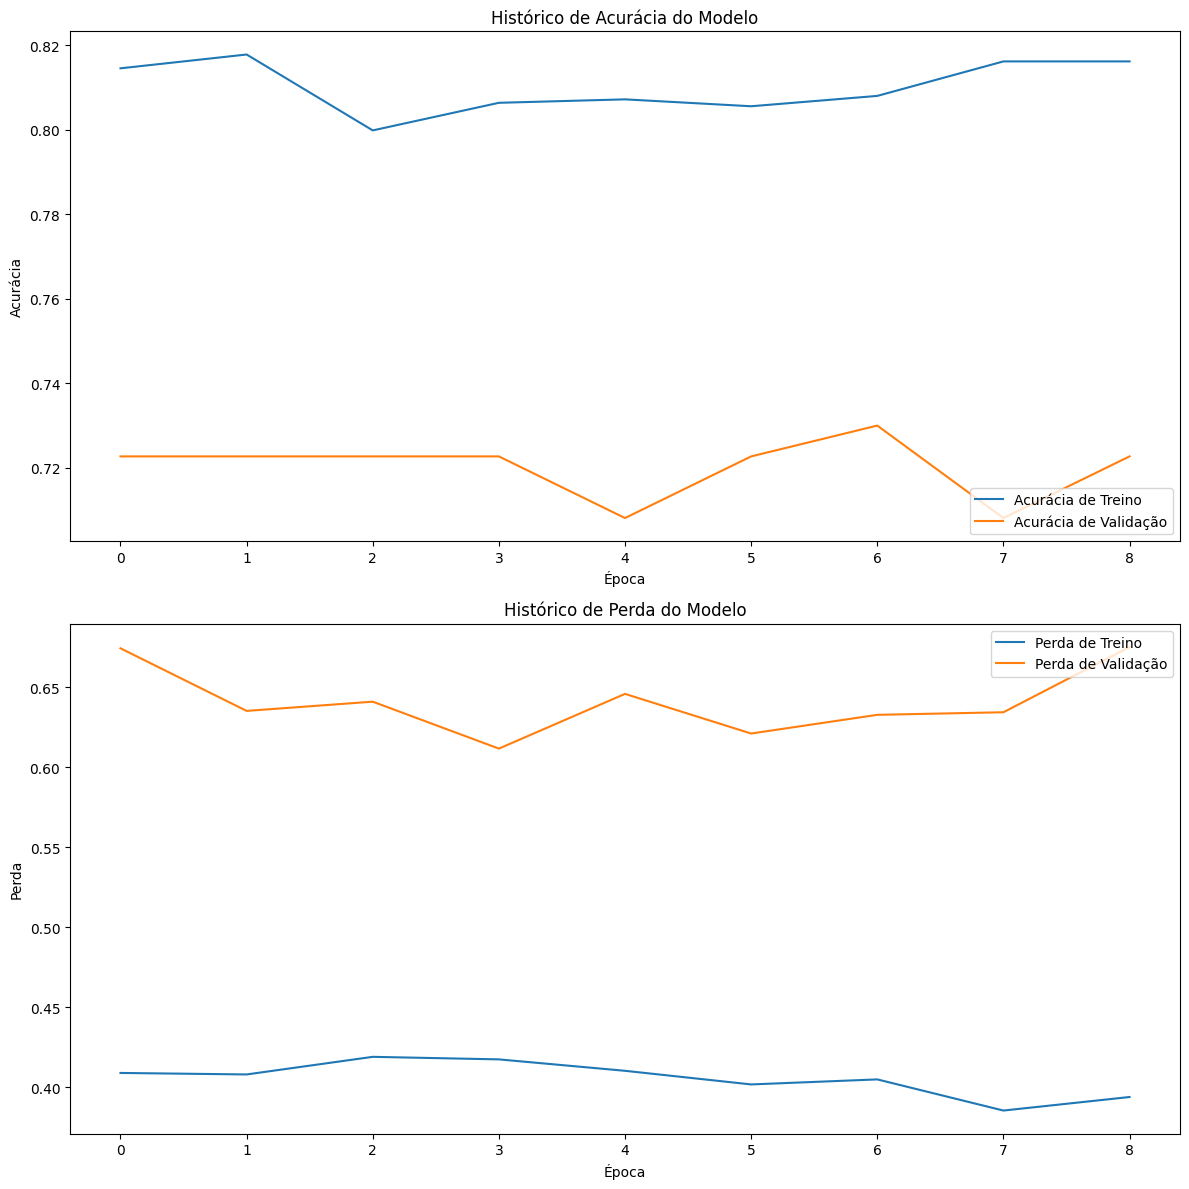

In [13]:
# CÉLULA 9 (CORRIGIDA): Plotar o histórico de treino

# Importar a biblioteca de plotagem AQUI MESMO para garantir que ela existe
import matplotlib.pyplot as plt

# Criar uma figura com dois subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plotar a acurácia
ax1.plot(history.history['accuracy'], label='Acurácia de Treino')
ax1.plot(history.history['val_accuracy'], label='Acurácia de Validação')
ax1.set_title('Histórico de Acurácia do Modelo')
ax1.set_ylabel('Acurácia')
ax1.set_xlabel('Época')
ax1.legend(loc='lower right')

# Plotar a perda (loss)
ax2.plot(history.history['loss'], label='Perda de Treino')
ax2.plot(history.history['val_loss'], label='Perda de Validação')
ax2.set_title('Histórico de Perda do Modelo')
ax2.set_ylabel('Perda')
ax2.set_xlabel('Época')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [14]:
# CÉLULA 10: Avaliar o modelo no conjunto de teste

# Fazer a avaliação final
loss, accuracy = model.evaluate(X_test_seq, y_test_adj, verbose=0)

print("--- Avaliação Final no Conjunto de Teste ---")
print(f"Perda (Loss) no Teste: {loss:.4f}")
print(f"Acurácia (Accuracy) no Teste: {accuracy:.4f} (ou {accuracy*100:.2f}%)")


--- Avaliação Final no Conjunto de Teste ---
Perda (Loss) no Teste: 1.1242
Acurácia (Accuracy) no Teste: 0.6588 (ou 65.88%)


In [18]:
# CÉLULA 11 (CORRIGIDA): Guardar o modelo e o scaler

import joblib
import os # <-- IMPORTAÇÃO ADICIONADA AQUI

# Definir os caminhos para guardar
model_path = '../models/oracle_lstm_v1.h5'
scaler_path = '../models/scaler_v1.pkl'

# Criar a pasta 'models' se ela não existir
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Guardar o modelo do TensorFlow
model.save(model_path)

# Guardar o scaler do Scikit-learn
joblib.dump(scaler, scaler_path)

print(f"Modelo guardado em: {model_path}")
print(f"Scaler guardado em: {scaler_path}")


Modelo guardado em: ../models/oracle_lstm_v1.h5
Scaler guardado em: ../models/scaler_v1.pkl
